In [1]:
import pandas as pd
import sqlite3
from treelib import Tree
from sklearn.metrics import multilabel_confusion_matrix, classification_report, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
db_file = '/Users/francisco/Library/CloudStorage/OneDrive-Personal/Francisco/GitHub/GenerativeDebunking/database/CARDS.db'

In [3]:
# 1 query all claims
# 2 query all premise, hidden premises True
# 3 query all premises, hidden premises Pred
# 4 query correct premises True vs Pred
# 5 query correct hidden premises True vs Pred

In [4]:
def read_query(query, db_file):
    # Create a connection to the database
    conn = sqlite3.connect(db_file)
    # Iread the query into a pd.DataFrame
    df = pd.read_sql_query(query, conn)
    # close the connection
    conn.close()
    return df

In [5]:
q1 = """SELECT *
        FROM
		Claims"""

In [6]:
d1 = read_query(q1, db_file)
d1.shape[0]

46

In [7]:
q2 = """SELECT
    c.claims_id,
    tp.premise AS true_premise,
    tp.premise_identifier AS true_premise_identifier,
    tf.fallacy_text AS true_fallacy,
	tp.is_hidden as tp_hidden
    FROM
    Claims c
    LEFT JOIN
    True_Premises tp ON c.claims_id = tp.claims_id
    LEFT JOIN
    True_Fallacies tf ON tp.premise_id = tf.premise_id
    WHERE
	tp.premise_identifier != 'C'"""

d2 = read_query(q2, db_file)
d2.value_counts('tp_hidden')


tp_hidden
1    65
0    57
dtype: int64

In [8]:
q3 = """SELECT
    c.claims_id,
    pp.premise AS pred_premise,
    pp.premise_identifier AS pred_premise_identifier,
    pf.fallacy_text AS pred_fallacy,
	pp.is_hidden as pp_hidden
    FROM
    Claims c
    LEFT JOIN
    Pred_Premises pp ON c.claims_id = pp.claims_id
    LEFT JOIN
    Pred_Fallacies pf ON pp.premise_id = pf.premise_id
    WHERE
	pp.premise_identifier != 'C'"""

d3 = read_query(q3, db_file)
d3 = d3.drop(index=0).reset_index(drop=True)
d3.value_counts('pp_hidden')




pp_hidden
0    58
1    28
dtype: int64

In [9]:
# q4:

# d2 = True
# d3 = Pred

d4 = d2[d2['tp_hidden'] == 0].merge(d3[d3['pp_hidden'] == 0], on='claims_id', how='inner')\
    .query("true_premise_identifier == pred_premise_identifier")\
    .fillna({'true_fallacy': 'No Fallacy'})\
    .replace({'pred_fallacy': {'no fallacy.': 'No Fallacy'}})\
    .assign(true_fallacy=lambda x: x['true_fallacy'].str.lower(),
            pred_fallacy=lambda x: x['pred_fallacy'].str.lower())\
    .reset_index(drop=True)


d4
d4.query("true_fallacy != pred_fallacy")

,claims_id,true_premise,true_premise_identifier,true_fallacy,tp_hidden,pred_premise,pred_premise_identifier,pred_fallacy,pp_hidden
1,2,Parts of Greenland's ice sheet are not melting.,P1,cherry picking,0,Parts of Greenland's ice sheet are not melting,P1,no fallacy,0
4,5,Current climate change is driven by natural fa...,P1,cherry picking,0,Current climate change is driven by natural fa...,P1,false analogy,0
5,5,Current climate change is driven by natural fa...,P1,cherry picking,0,Current climate change is driven by natural fa...,P1,misrepresentation,0
6,5,Current climate change is driven by natural fa...,P1,cherry picking,0,Current climate change is driven by natural fa...,P1,single cause,0
7,5,Current climate change is driven by natural fa...,P1,slothful induction,0,Current climate change is driven by natural fa...,P1,false analogy,0
8,5,Current climate change is driven by natural fa...,P1,slothful induction,0,Current climate change is driven by natural fa...,P1,misrepresentation,0
9,5,Current climate change is driven by natural fa...,P1,slothful induction,0,Current climate change is driven by natural fa...,P1,single cause,0
11,6,Cold weather events are occuring.,P1,anecdote,0,Cold weather events are occurring,P1,no fallacy,0
13,7,There's been no warming over a short period.,P1,slothful induction,0,There's been no warming over a short period.,P1,cherry picking,0
14,8,Sea levels within a specific time period or re...,P1,cherry picking,0,Sea levels within a specific time period or re...,P1,no fallacy,0


In [10]:
d5 = d2[d2['tp_hidden'] == 1].merge(d3[d3['pp_hidden'] == 1], on='claims_id', how='left')\
    .fillna({'true_fallacy': 'No Fallacy'})\
    .replace({'pred_fallacy': {'no fallacy.': 'No Fallacy'}})\
    .assign(true_fallacy=lambda x: x['true_fallacy'].str.lower(),
            pred_fallacy=lambda x: x['pred_fallacy'].str.lower())\
    .reset_index(drop=True)
    # .query("true_fallacy != pred_fallacy")\
    # .dropna()\
d5

,claims_id,true_premise,true_premise_identifier,true_fallacy,tp_hidden,pred_premise,pred_premise_identifier,pred_fallacy,pp_hidden
0,1,Cooling is the only driver of sea ice gain the...,P3,impossible expectations,1,Antarctic sea ice is a reliable indicator of g...,HP,no fallacy,1.0
1,1,Cooling is the only driver of sea ice gain the...,P3,single cause,1,Antarctic sea ice is a reliable indicator of g...,HP,no fallacy,1.0
2,2,All parts of ice sheets must be melting under ...,P2,impossible expectations,1,If parts of Greenland's ice sheet are not melt...,HP,no fallacy,1.0
3,2,All parts of ice sheets must be melting under ...,P2,single cause,1,If parts of Greenland's ice sheet are not melt...,HP,no fallacy,1.0
4,3,If Arctic sea ice maximum extent hasn't change...,P2,cherry picking,1,"In the short term, if something hasn't changed...",HP,no fallacy,1.0
...,...,...,...,...,...,...,...,...,...
60,41,If the media supports the mainstream view on c...,P2,ad hominem,1,"If the media supports the mainstream view, the...",HP,ad hominem,1.0
61,41,If the media supports the mainstream view on c...,P2,misrepresentation,1,"If the media supports the mainstream view, the...",HP,ad hominem,1.0
62,42,If governments or politicians support the main...,P2,ad hominem,1,"If someone supports a particular view, they ar...",HP,ad hominem,1.0
63,42,If governments or politicians support the main...,P2,misrepresentation,1,"If someone supports a particular view, they ar...",HP,ad hominem,1.0


In [11]:
d5.query("true_fallacy == pred_fallacy")

,claims_id,true_premise,true_premise_identifier,true_fallacy,tp_hidden,pred_premise,pred_premise_identifier,pred_fallacy,pp_hidden
24,16,"If temperature affects CO2, then CO2 cannot af...",P2,false choice,1,If something lags behind another thing in the ...,HP,false choice,1.0
50,32,"Without public support, climate policy is impo...",P2,no fallacy,1,If the public is not convinced about the need ...,HP,no fallacy,1.0
60,41,If the media supports the mainstream view on c...,P2,ad hominem,1,"If the media supports the mainstream view, the...",HP,ad hominem,1.0
62,42,If governments or politicians support the main...,P2,ad hominem,1,"If someone supports a particular view, they ar...",HP,ad hominem,1.0
64,45,Secret actions by governing bodies and corpora...,P2,conspiracy theory,1,"If actions are done secretly, they must be par...",HP,conspiracy theory,1.0


In [12]:
check = list()

d2['true_fallacy'] = d2['true_fallacy'].fillna('no fallacy')

for row in d3.index:
    claim = d3.loc[row, 'claims_id']
    premise_identifier = d3.loc[row, 'pred_premise_identifier']
    fallacy = d3.loc[row, 'pred_fallacy']

    

    if d3.loc[row, 'pp_hidden'] == 0:

        try: 
            gold = d2[(d2['claims_id'] == claim) & (d2['true_premise_identifier'] == premise_identifier) & (d2['tp_hidden'] == 0)]
            
            if fallacy in gold['true_fallacy'].to_list():
                check.append(True)
            else:
                check.append(False)
        except:
            check.append(False)


    else:

        try: 
            gold = d2[(d2['claims_id'] == claim) & (d2['tp_hidden'] == 1)]
            
            if fallacy in gold['true_fallacy'].to_list():
                check.append(True)
            else:
                check.append(False)
        except:
            check.append(False)

In [24]:
# Create an instance of the Tree class
tree = Tree()

# Create the nodes of the tree with data
tree.create_node("Claims", "claims", data={"value": d1.shape[0]})  # root node
tree.create_node('True', 'TRUE', parent='claims', data={"value": d2.shape[0]})
tree.create_node('Pred', 'PRED', parent='claims', data={"value": d3.shape[0]})
tree.create_node('explicit', 'TRUE_explicit', parent='TRUE', data={"value": d2.value_counts('tp_hidden')[0]})
tree.create_node('hidden', 'TRUE_hidden', parent='TRUE', data={"value": d2.value_counts('tp_hidden')[1]})
tree.create_node('explicit', 'PRED_explicit', parent='PRED', data={"value": d3.value_counts('pp_hidden')[0]})
tree.create_node('hidden', 'PRED_hidden', parent='PRED', data={"value": d3.value_counts('pp_hidden')[1]})


tree.create_node('correct', 'PRED_explicit_c', parent='PRED_explicit', data={"value": d3[(d3['check'] == True) & (d3['pp_hidden'] == 0)].shape[0]})
tree.create_node('incorrect', 'PRED_explicit_i', parent='PRED_explicit', data={"value": d3[(d3['check'] == False) & (d3['pp_hidden'] == 0)].shape[0]})

tree.create_node('correct', 'PRED_hidden_c', parent='PRED_hidden', data={"value": d3[(d3['check'] == True) & (d3['pp_hidden'] == 1)].shape[0]})
tree.create_node('incorrect', 'PRED_hidden_i', parent='PRED_hidden', data={"value": d3[(d3['check'] == False) & (d3['pp_hidden'] == 1)].shape[0]})

# tree.create_node("Premises", "premises", parent="claims", data={"value": 43})
# tree.create_node("Hidden Premises", "hidden premises", parent="claims", data={"value": 32})
# tree.create_node("Fallacies", "fallacies", parent="premises", data={"value": 23})
# tree.create_node("Fallacies", "hp fallacies", parent="hidden premises", data={"value": 23})
# tree.create_node("Non fallacies", "non fallacies", parent="hidden premises", data={"value": 23})
# tree.create_node("Non fallacies", "hp non fallacies", parent="premises", data={"value": 23})

# Set the custom string representation for each node
for node in tree.all_nodes():
    node.tag = f"{node.tag} {node.data['value']}"

# Show the tree diagram
tree.show()


Claims 46
├── Pred 86
│   ├── explicit 58
│   │   ├── correct 34
│   │   └── incorrect 24
│   └── hidden 28
│       ├── correct 5
│       └── incorrect 23
└── True 122
    ├── explicit 57
    └── hidden 65



In [26]:
tree.to_graphviz("tree.dot", shape='plain')

In [ ]:
# plot on tree googlecolab:

# edit tree.dot with text editor and add rankdir=LR; as below to make the figure horizontal

# digraph {
#     rankdir=LR;
#     // Rest of your graph definition
# }

# On colab run:

# import graphviz

# # Path to the .dot file
# dot_file_path = '/content/tree2.dot'

# # Create a Graphviz graph from the .dot file
# graph = graphviz.Source.from_file(dot_file_path)

# # Render and display the graph
# graph


In [144]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

labels = [list(set(d3['pred_fallacy'].to_list()).union(set(d2['true_fallacy'].to_list())))]

mlb.fit(labels)
mlb.classes_


array(['ad hominem', 'ambiguity', 'anecdote', 'cherry picking',
       'circular reasoning', 'conspiracy theory', 'false analogy',
       'false choice', 'false equivalence', 'hasty generalization',
       'impossible expectations', 'misrepresentation', 'no fallacy',
       'oversimplification', 'red herring', 'single cause',
       'slothful induction'], dtype=object)

In [139]:
targets = []


for row in d3.index:
    claim = d3.loc[row, 'claims_id']
    premise_identifier = d3.loc[row, 'pred_premise_identifier']
    fallacy = d3.loc[row, 'pred_fallacy']

    if d3.loc[row, 'pp_hidden'] == 0:
        gold = d2[(d2['claims_id'] == claim) & (d2['true_premise_identifier'] == premise_identifier) & (d2['tp_hidden'] == 0)]
        targets.append(gold['true_fallacy'].to_list())

    else:
        gold = d2[(d2['claims_id'] == claim) & (d2['tp_hidden'] == 1)]
        targets.append(gold['true_fallacy'].to_list())

In [145]:
target = mlb.transform(targets)
target

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [156]:
preds = mlb.transform([tuple([x]) for x in d3['pred_fallacy'].to_list()])
preds

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [141]:
preds = []
for i in d3['pred_fallacy']:
    pred = [int(label == i) for label in labels]
    preds.append(pred)

preds

target = []
for i in targets:
    output = [int(label in i) for label in labels]
    target.append(output)

wrong_premises = [index for index, vector in enumerate(target) if all(element == 0 for element in vector)]
wrong_premises


# Deleting vectors at zero vector indices
# It's important to iterate in reverse order when deleting elements from a list to avoid index errors.
for index in sorted(wrong_premises, reverse=True):
    del target[index]
    del preds[index]



In [252]:
print(classification_report(target, preds, target_names=mlb.classes_, zero_division=0.0))

                         precision    recall  f1-score   support

             ad hominem       1.00      1.00      1.00         4
              ambiguity       0.00      0.00      0.00         0
               anecdote       0.00      0.00      0.00         1
         cherry picking       1.00      0.11      0.19        19
     circular reasoning       0.00      0.00      0.00         0
      conspiracy theory       1.00      1.00      1.00         3
          false analogy       0.00      0.00      0.00         0
           false choice       0.25      1.00      0.40         1
      false equivalence       0.00      0.00      0.00         2
   hasty generalization       0.00      0.00      0.00         0
impossible expectations       1.00      0.20      0.33         5
      misrepresentation       0.00      0.00      0.00         6
             no fallacy       0.44      0.93      0.60        30
     oversimplification       0.00      0.00      0.00         9
            red herring 

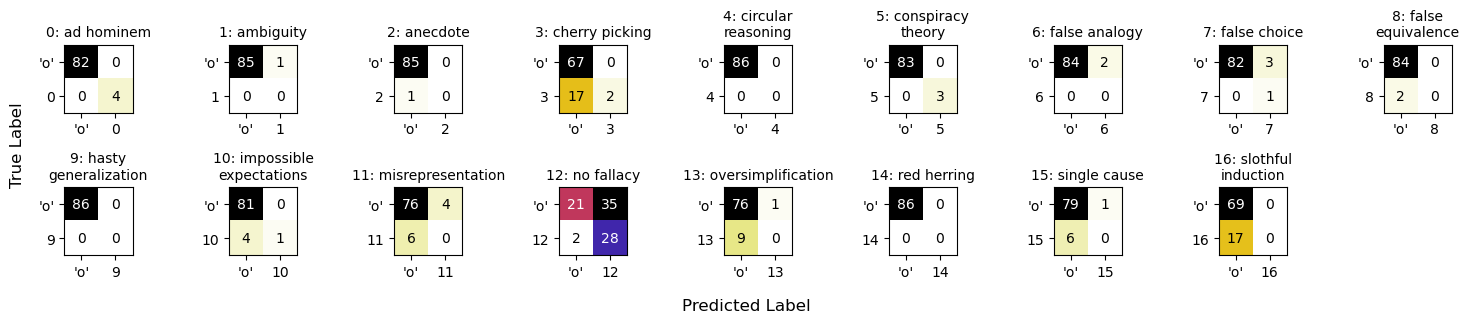

In [249]:
cms = multilabel_confusion_matrix(target, preds)

num_rows, num_cols = 2, 9

# for j in ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r']:
fig = plt.figure(figsize=(15, 3))
for i, cm in enumerate(cms):
    ax = fig.add_subplot(num_rows, num_cols, i+1)
    disp = ConfusionMatrixDisplay(cm, display_labels=['\'o\'' ,i])
    disp.plot(include_values=True, cmap='CMRmap_r', ax=ax, colorbar=False)

    nl = '\n'
    title = f'{i}: {mlb.classes_[i]}'
    if len(title) > 19:
        aux = mlb.classes_[i].replace(' ', '\n')
        title = f'{i}: {aux}'

    ax.set_title(title, fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('')
    # ax.yticks(rotation='vertical')
# Add x-axis label and y-axis label for the overall figure
fig.text(0.5, 0.02, '\n\nPredicted Label', ha='center', va='center', fontsize=12)
fig.text(0.02, 0.5, 'True Label\n', ha='center', va='center', rotation='vertical', fontsize=12)
plt.tight_layout()
plt.show()


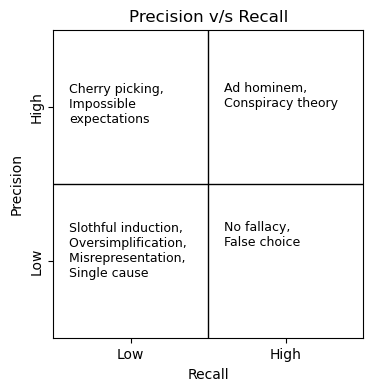

In [305]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xticks([0.25, 0.75])
ax.set_yticks([0.25, 0.75])
ax.set_xticklabels(['Low', 'High'])
ax.set_yticklabels(['Low', 'High'], rotation='vertical', va='center')
ax.axvline(0.5, c='k', lw=1)
ax.axhline(0.5, c='k', lw=1)

# Add text in the upper right quadrant
ax.text(0.55, 0.3, 'No fallacy, \nFalse choice', fontsize=9)
ax.text(0.05, 0.7, 'Cherry picking, \nImpossible \nexpectations', fontsize=9)
ax.text(0.55, 0.75, 'Ad hominem, \nConspiracy theory', fontsize=9)
ax.text(0.05, 0.2, 'Slothful induction, \nOversimplification, \nMisrepresentation, \nSingle cause', fontsize=9)

# Add precision and recall labels
plt.title('Precision v/s Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.show()